In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats

In [35]:
df = pd.read_csv('car_prices.csv')

In [3]:
df_copy = pd.read_csv('car_prices.csv')

In [36]:
df.head()

,year,make,model,trim,body,transmission,vin,state,condition,odometer,color,interior,seller,mmr,sellingprice,saledate
0,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg566472,ca,5.0,16639.0,white,black,kia motors america inc,20500.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
1,2015,Kia,Sorento,LX,SUV,automatic,5xyktca69fg561319,ca,5.0,9393.0,white,beige,kia motors america inc,20800.0,21500.0,Tue Dec 16 2014 12:30:00 GMT-0800 (PST)
2,2014,BMW,3 Series,328i SULEV,Sedan,automatic,wba3c1c51ek116351,ca,45.0,1331.0,gray,black,financial services remarketing (lease),31900.0,30000.0,Thu Jan 15 2015 04:30:00 GMT-0800 (PST)
3,2015,Volvo,S60,T5,Sedan,automatic,yv1612tb4f1310987,ca,41.0,14282.0,white,black,volvo na rep/world omni,27500.0,27750.0,Thu Jan 29 2015 04:30:00 GMT-0800 (PST)
4,2014,BMW,6 Series Gran Coupe,650i,Sedan,automatic,wba6b2c57ed129731,ca,43.0,2641.0,gray,black,financial services remarketing (lease),66000.0,67000.0,Thu Dec 18 2014 12:30:00 GMT-0800 (PST)


# Data Preprocessing Overview
. Below, we detail the specific imputation techniques used for different features based on their distribution and relevance to the predictive model.


In [49]:
# Check for missing values
missing_values = df_merged.isnull().sum()
print("Missing Values:")
print(missing_values)

Missing Values:
year                            0
make                        10301
model                       10399
trim                        10651
body                        13195
transmission                65352
vin                             4
state                           0
condition                   11820
odometer                       94
color                         749
interior                      749
seller                          0
mmr                            38
sellingprice                   12
saledate                       12
Average Sentiment Score    159355
dtype: int64


# Removal of Specific Features

In the preprocessing phase, certain features were removed from the dataset due to their limited predictive value or redundancy. The rationale behind the removal of each feature is as follows:

## VIN (Vehicle Identification Number)
- **Reason for Removal**: The VIN is a unique identifier for each vehicle. While it is unique and can be useful for tracking individual vehicles, it does not provide any predictive value for modeling purposes. Including this feature in the dataset could lead to model overfitting, as it essentially memorizes vehicle-specific details rather than learning generalizable trends.

## Sale Date
- **Reason for Removal**: The `saledate` feature represents the date on which a vehicle was sold. Initial analysis indicated that the sale date does not show a consistent pattern or correlation with the vehicle's selling price when other temporal factors are considered (such as the vehicle's age at sale, which is derived from the `year` feature). Thus, including this feature would not contribute to the predictive accuracy of the model.

## Condition
- **Reason for Removal**: The `condition` feature, which ranges from 1 to 50, was intended to represent the vehicle's state at the time of sale. However, the scale's granularity and the method of assessment are not standardized or clearly defined, making it difficult to interpret and use effectively in predictive modeling. This lack of descriptiveness and standardization can introduce noise into the model, leading to poorer performance.



In [50]:
# Convert text columns to lowercase using a lambda function as we realized some of similar vehicle had both upper and lower giving conflicting results
df_merged[df_merged.select_dtypes(include=['object']).columns] = df_merged.select_dtypes(include=['object']).apply(lambda x: x.str.lower())

df_merged.drop(columns=['vin','saledate','condition'], inplace=True)

## Imputation of Numerical Features

We use mean imputation for the 'odometer', 'mmr', and 'Average Sentiment Score' fields:

- **Odometer and MMR**: These features are crucial for predicting vehicle prices and typically follow a normal distribution, making mean imputation a suitable choice for handling missing values without biasing the dataset too much.

- **Average Sentiment Score**: As a derived feature, the average sentiment score is expected to be normally distributed around the mean sentiment of all vehicles, making the mean a reasonable choice for imputation.


In [51]:
df_merged['odometer'].fillna(df_merged['odometer'].mean(), inplace=True)
df_merged['mmr'].fillna(df_merged['mmr'].mean(), inplace=True)

# Fill missing values with 'Other' category
df_merged['make'] = df_merged['make'].fillna('Other')
df_merged['model'] = df_merged['model'].fillna('Other')
df_merged['trim'] = df_merged['trim'].fillna('Other')
df_merged['color'] = df_merged['color'].fillna('Other')

# Fill missing values with mode
df_merged['body'] = df_merged['body'].fillna(df_merged['body'].mode()[0])
df_merged['transmission'] = df_merged['transmission'].fillna(df_merged['transmission'].mode()[0])
df_merged['interior'] = df_merged['interior'].fillna(df_merged['interior'].mode()[0])

# Impute missing values in the average sentiment score column with the mean or median
imputed_mean = df_merged['Average Sentiment Score'].mean()
df_merged['Average Sentiment Score'].fillna(imputed_mean, inplace=True)
df_merged = df_merged.dropna(subset=['sellingprice'])

# Verify that there are no missing values remaining
df_merged.isnull().sum()


year                       0
make                       0
model                      0
trim                       0
body                       0
transmission               0
state                      0
odometer                   0
color                      0
interior                   0
seller                     0
mmr                        0
sellingprice               0
Average Sentiment Score    0
dtype: int64

## Outlier Removal Using Z-Score

Outliers can significantly skew the results of our data analysis and predictive modeling. To ensure a robust model, we need to handle outliers appropriately. In this dataset, we employ the Z-score method for identifying and removing outliers in numerical columnsrs. 

### Process
We calculate the Z-scores for each numerical feature. A common practice is to consider data points with a Z-score less than -2 or greater than +2 as outliers. These thresholds capture data points that are significantly different from the rest, assuming the data follows a normal distribution.

### Implementation
- We first isolate the numerical columns of our dataset.
- We then compute the Z-score for each value in these columns.
- Data points where the Z-score of any feature exceeds the threshold of 2 (in absolute value) are removed. This approach helps in maintaining a more standardized and clean dataset for our subsequent analyses and modeling.

The removal of these outliers should help improve the accuracy and generalizability of our predictive models.


In [52]:
# Exclude 'Average Sentiment Score' column from the selection
numerical_columns = df_merged.select_dtypes(include=['float64', 'int64']).drop(columns=['Average Sentiment Score']).columns

# Remove outliers using Z-score
z_scores = stats.zscore(df_merged[numerical_columns])
clean_df = df_merged[(z_scores < 2).all(axis=1)]
clean_df.shape

(511820, 14)

## Feature Normalization with Min-Max Scaling

### Overview
We apply Min-Max Scaling to normalize numerical features ('year', 'odometer', 'mmr', and 'Average Sentiment Score') to a [0, 1] scale. This standardization is crucial for models that are sensitive to the magnitude of input features and ensures all features contribute equally during training.

### Why Min-Max Scaling?
- **Uniform Scale**: Ensures all numerical features contribute equally to the model's decisions.
- **Maintains Distribution**: Preserves the original distribution of values without distorting differences in range.
- **Compatibility**: Necessary for many machine learning algorithms that rely on distance calculation rules.

This normalization is implemented in the `normalize_features` function, which returns the scaled DataFrame and a dictionary containing the scaler objects for each feature.


In [24]:
from sklearn.preprocessing import MinMaxScaler

def normalize_features(df):
    # Copy the original DataFrame to avoid modifying the input
    normalized_df = df.copy()

    # Numerical columns to be normalized
    numerical_cols = ['year', 'odometer', 'mmr']

    # Categorical columns to be encoded
    categorical_cols = [col for col in df.columns if col not in numerical_cols]

    # Normalize numerical features using Min-Max Scaling
    scaler_dict = {}
    for col in numerical_cols:
        scaler = MinMaxScaler()
        normalized_df[col] = scaler.fit_transform(df[[col]])
        scaler_dict[col] = scaler
        
    return normalized_df, scaler_dict

In [25]:

cleaner_df, scalers = normalize_features(clean_df)
cleaner_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 503424 entries, 0 to 558836
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   year                     503424 non-null  float64
 1   make                     503424 non-null  object 
 2   model                    503424 non-null  object 
 3   trim                     503424 non-null  object 
 4   body                     503424 non-null  object 
 5   transmission             503424 non-null  object 
 6   state                    503424 non-null  object 
 7   odometer                 503424 non-null  float64
 8   color                    503424 non-null  object 
 9   interior                 503424 non-null  object 
 10  seller                   503424 non-null  object 
 11  mmr                      503424 non-null  float64
 12  sellingprice             503424 non-null  float64
 13  Average Sentiment Score  503424 non-null  float64
dtypes: float6

## Encoding Categorical Variables

### Why Label Encoding?
- **Model Compatibility**: Many machine learning models require all input and feature data to be numeric. Label encoding converts categorical labels into integers, making data suitable for model training.
- **Efficiency**: Label encoding is a straightforward approach that assigns each unique category a unique integer based on alphabetical ordering.

### Implementation
- **Process**: For each categorical column in the dataset, we apply Label Encoding, which transforms text labels into numerical form.
- **Dictionary Storage**: We store each column's encoder in a dictionary, allowing for consistent inverse transformations on new or output data, and ensuring that we can revert encoded predictions back to their original categorical labels.

This step is crucial for preparing our dataset for modeling, as it converts all text data into a format that can be effectively handled by our algorithms.


In [53]:
from sklearn.preprocessing import LabelEncoder

# Initialize a dictionary to store label encoders for each categorical column
label_encoders = {}

# Iterate over categorical columns and encode them in df
for column in clean_df.select_dtypes(include=['object']):
    label_encoder = LabelEncoder()
    clean_df[column] = label_encoder.fit_transform(clean_df[column])
    # Store the label encoder for each column
    label_encoders[column] = label_encoder


 


C:\Users\myahs\AppData\Local\Temp\ipykernel_9004\922113010.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[column] = label_encoder.fit_transform(clean_df[column])
C:\Users\myahs\AppData\Local\Temp\ipykernel_9004\922113010.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_df[column] = label_encoder.fit_transform(clean_df[column])
C:\Users\myahs\AppData\Local\Temp\ipykernel_9004\922113010.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try

In [54]:
clean_df.head()

,year,make,model,trim,body,transmission,state,odometer,color,interior,seller,mmr,sellingprice,Average Sentiment Score
0,2015,26,648,1077,37,0,29,16639.0,44,1,6787,20500.0,21500.0,0.274831
1,2015,26,648,1077,37,0,29,9393.0,44,0,6787,20800.0,21500.0,0.274831
2,2014,3,10,269,34,0,29,1331.0,34,1,4691,31900.0,30000.0,0.284223
3,2015,54,595,1467,34,0,29,14282.0,44,1,12992,27500.0,27750.0,0.372500
5,2015,40,70,116,34,0,29,5554.0,34,1,4345,15350.0,10900.0,0.180292


In [55]:
print(clean_df['Average Sentiment Score'].describe())


count    511820.000000
mean          0.283584
std           0.061116
min          -0.248519
25%           0.267482
50%           0.284223
75%           0.319207
max           0.733333
Name: Average Sentiment Score, dtype: float64


## Data Visualizations Based on the Cleaned Data

C:\Users\myahs\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


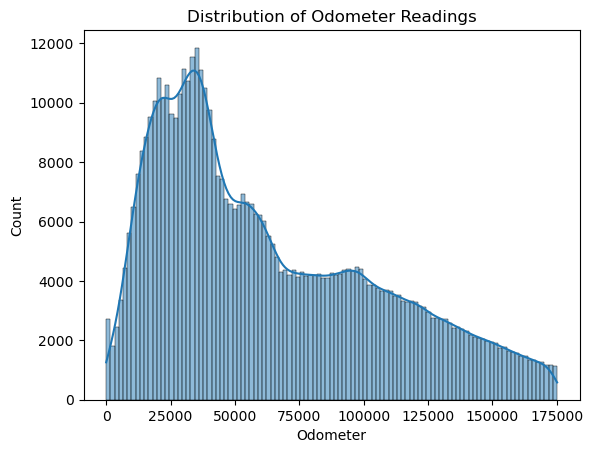

In [72]:
# Histogram for 'odometer'
sns.histplot(clean_df['odometer'], kde=True)  # kde=True adds a kernel density estimate
plt.title('Distribution of Odometer Readings')
plt.xlabel('Odometer')
plt.ylabel('Count')
plt.show()


The histogram has a high peak between 0 and 50,000, suggesting a higher frequency of vehicles with lower odometer readings. Beyond 50,000, the distribution begins to taper off, showing a gradual decline as the readings increase. The frequency of occurrences declines steadily as odometer readings increase toward 175,000, indicating that fewer vehicles have higher odometer readings

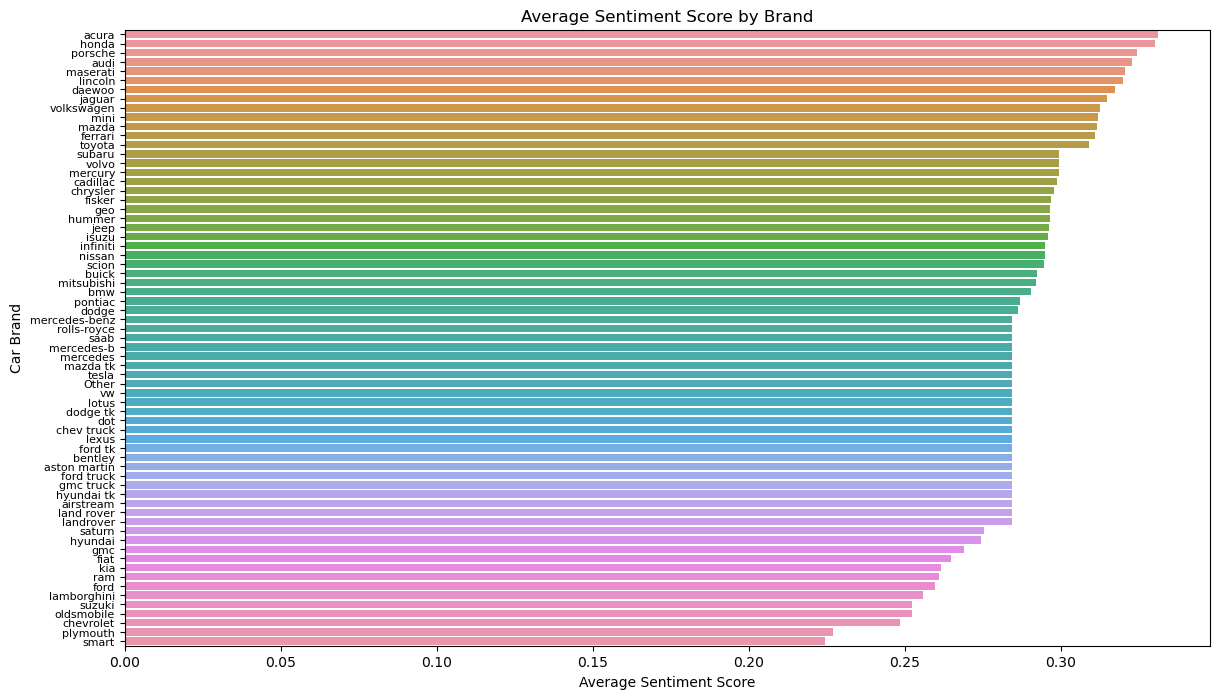

In [86]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'df_merged' is your DataFrame and it includes 'make' and 'Average Sentiment Score' columns
# Filter out rows with negative 'Average Sentiment Score'
positive_sentiments = df_merged[df_merged['Average Sentiment Score'] >= 0]

# Group by 'make', calculate the mean sentiment score, and sort from highest to lowest
avg_sentiment_by_brand = positive_sentiments.groupby('make')['Average Sentiment Score'].mean().reset_index()
avg_sentiment_by_brand_sorted = avg_sentiment_by_brand.sort_values('Average Sentiment Score', ascending=False)

# Set a larger figure size for clarity
plt.figure(figsize=(14, 8))
 # Increase the height to spread out the y-axis labels

# Create a horizontal bar plot
sns.barplot(data=avg_sentiment_by_brand_sorted, x='Average Sentiment Score', y='make', orient='h')

# Title and labels
plt.title('Average Sentiment Score by Brand')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Car Brand')

# Adjust the size of the y-axis labels if necessary
plt.yticks(fontsize=8)  #

plt.show()


 Brands are ordered from most favorable to least based on the average sentiment score, allowing for easy identification of top-performing brands in terms of customer sentiment. This visualization can be particularly useful for businesses looking to prioritize inventory, enhance brand partnerships, or focus marketing efforts on the most positively received brands.

### Insights/ Usage
Inventory Decisions: Higher sentiment scores for specific brands might indicate a greater demand, suggesting that stocking more of those cars could be beneficial.
Marketing Strategies: Brands with higher sentiment scores might be good candidates for marketing campaigns, customer testimonials, or promotions.
Customer Relationship Management: Brands with lower sentiment scores might require additional customer support or improvements to meet customer expectations.

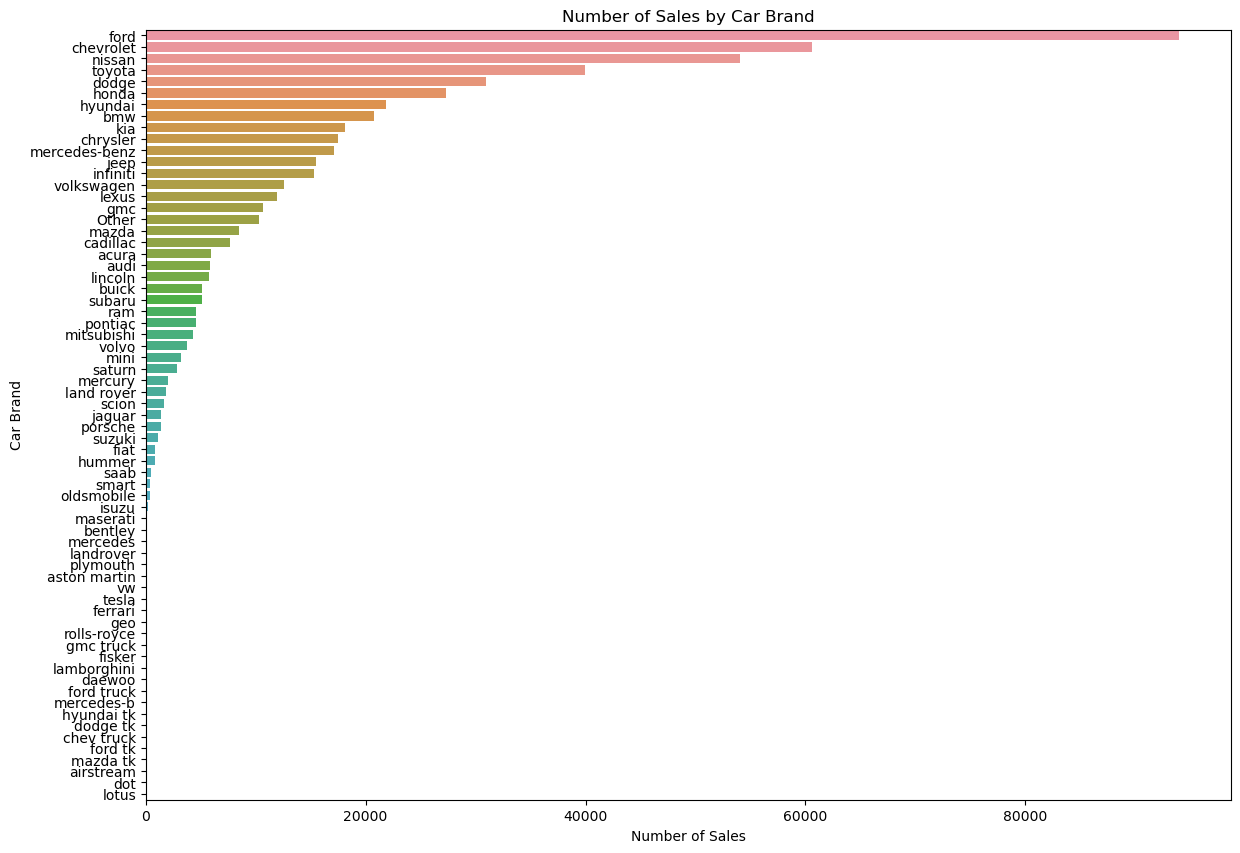

In [91]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the count (sales) for each make
sales_by_make = df_merged['make'].value_counts().reset_index()
sales_by_make.columns = ['make', 'Sales Count']

# Sort the DataFrame by 'Sales Count' to see which make has more sales
sales_by_make_sorted = sales_by_make.sort_values('Sales Count', ascending=False)

# Set a larger figure size for clarity
plt.figure(figsize=(14, 10))

# Create a bar plot
sns.barplot(data=sales_by_make_sorted, x='Sales Count', y='make')

# Title and labels
plt.title('Number of Sales by Car Brand')
plt.xlabel('Number of Sales')
plt.ylabel('Car Brand')

# Adjust the size of the y-axis labels if necessary
plt.yticks(fontsize=10)

plt.show()


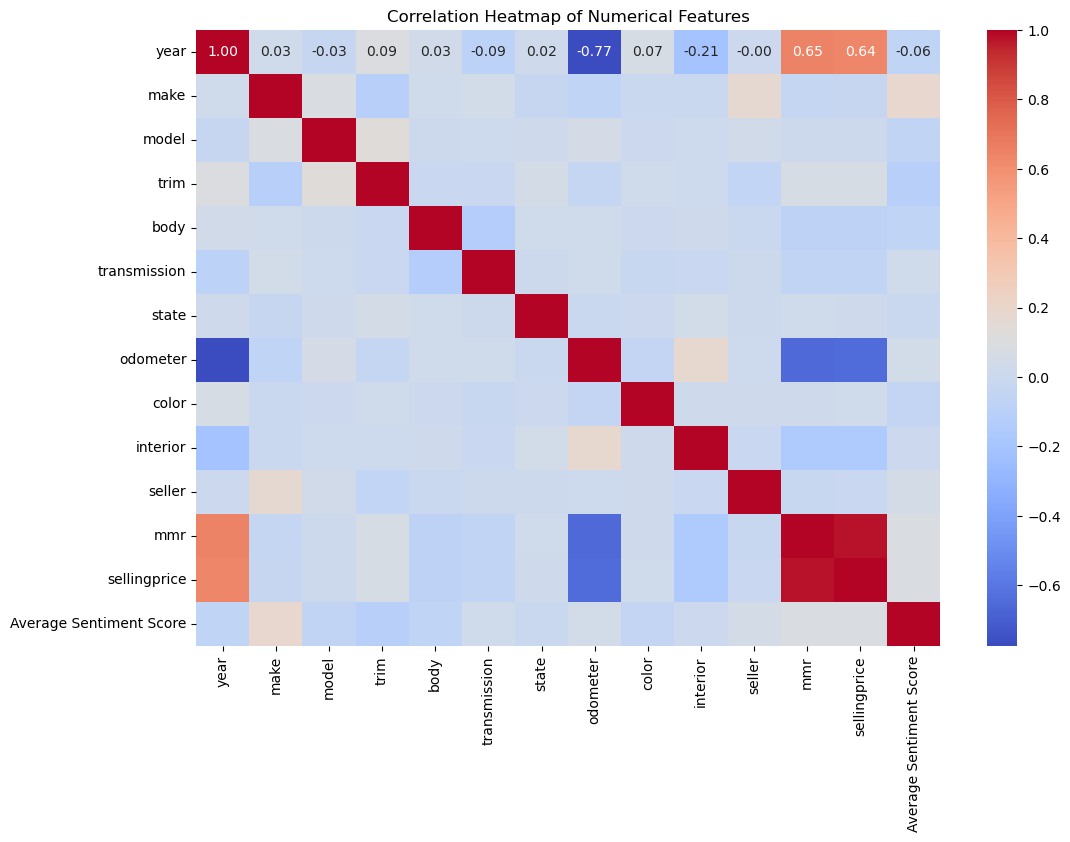

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt


# Set the figure size to make the heatmap larger
plt.figure(figsize=(12, 8))  # Adjust the width and height (e.g., 12 units by 8 units)

# Compute the correlation matrix
correlation_matrix = clean_df.corr()

# Create the heatmap with the specified figure size
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")  # 'fmt' sets decimal places for annotation

# Set the title and other plot adjustments
plt.title('Correlation Heatmap of Numerical Features')
plt.show()



The heatmap suggests that "sellingprice" has a strong positive correlation with "mmr" and a moderate negative correlation with "year," indicating a relationship between these features.

## Overview of Random Forest Regression on Sampled Data

This section outlines the Random Forest Regression analysis performed on a sampled subset of our comprehensive dataset. The objective is to efficiently estimate feature importance and model performance, enabling rapid iterations and insights. 

**Why Sample?** Sampling 10% of the data provides a representative yet more computationally tractable slice for initial modeling, maintaining overall data characteristics while reducing processing time.

**Process Flow:**
1. **Data Sampling**: Randomly sampled a fraction of the full dataset to ensure manageable computation.
2. **Feature/Target Split**: Isolated the features and target variable, with 'sellingprice' as the target, excluding 'Average Sentiment Score' from features for this analysis.
3. **Data Splitting**: Created training and testing datasets with an 80-20 split to train the model and subsequently evaluate its performance.
4. **Model Training**: Utilized a Random Forest Regressor to train on the subset, a method known for its robustness and effectiveness in handling diverse datasets.
5. **Feature Evaluation**: Post-training, we extracted feature importance to discern which factors most significantly influence selling price.

The accuracy and insights derived from this analysis are crucial for further model refinement and potentially scaling the approach to the full dataset.


In [58]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor



# Define the fraction of data you want to sample, e.g., 10%
fraction_of_data = 0.1

# Create a random sample of the data
clean_df_subset = clean_df.sample(frac=fraction_of_data, random_state=42)

# Split the subset into features and target variable
X_subset = clean_df_subset.drop(columns=['sellingprice','Average Sentiment Score'])
y_subset = clean_df_subset['sellingprice']

# Split the data into training and testing sets
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42
)

# Initialize Random Forest Regression model
rf_model_base = RandomForestRegressor()

# Fit Random Forest model to the subset of the training data
rf_model_base.fit(X_train_subset, y_train_subset)

# Get feature importances
feature_importances = rf_model_base.feature_importances_

# Get the indices of features sorted by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Select the top 5 important features for simplicity
selected_features = X_subset.columns[sorted_indices[:5]]

# Training and testing sets for selected features
rf_Xtrain_subset = X_train_subset[selected_features]
rf_Xtest_subset = X_test_subset[selected_features]

# Train Random Forest Regression model with selected features
rf_model_base.fit(rf_Xtrain_subset, y_train_subset)

# Make predictions on the test set
y_pred_rf_subset = rf_model_base.predict(rf_Xtest_subset)




In [60]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

# Define the fraction of data you want to sample, e.g., 10%
fraction_of_data = 0.1

# Create a random sample of the data
clean_df_subset = clean_df.sample(frac=fraction_of_data, random_state=42)

# Split the subset into features and target variable
X_subset = clean_df_subset.drop(columns=['sellingprice'])  # Ensure 'Average Sentiment Score' is included
y_subset = clean_df_subset['sellingprice']

# Split the data into training and testing sets
X_train_subset, X_test_subset, y_train_subset, y_test_subset = train_test_split(
    X_subset, y_subset, test_size=0.2, random_state=42
)

# Initialize Random Forest Regression model
rf_model_with_sentiment = RandomForestRegressor()  # Renamed model

# Fit Random Forest model to the subset of the training data
rf_model_with_sentiment.fit(X_train_subset, y_train_subset)

# Get feature importances
feature_importances = rf_model_with_sentiment.feature_importances_

# Get the indices of features sorted by importance
sorted_indices = np.argsort(feature_importances)[::-1]

# Select the top 5 important features for simplicity
selected_features = X_subset.columns[sorted_indices[:5]]

# Training and testing sets for selected features
rf_Xtrain_subset = X_train_subset[selected_features]
rf_Xtest_subset = X_test_subset[selected_features]

# Train Random Forest Regression model with selected features
rf_model_with_sentiment.fit(rf_Xtrain_subset, y_train_subset)

# Make predictions on the test set
y_pred_rf_subset = rf_model_with_sentiment.predict(rf_Xtest_subset)



In [59]:
# Evaluate Random Forest Regression model performance using R-squared score
r2_score_rf_subset = r2_score(y_test_subset, y_pred_rf_subset)
print("R-squared score for Random Forest Regression:", r2_score_rf_subset)

# Calculate Mean Squared Error
mse_subset = mean_squared_error(y_test_subset, y_pred_rf_subset)
print("Mean Squared Error:", mse_subset)

# Calculate Mean Absolute Error
mae_subset = mean_absolute_error(y_test_subset, y_pred_rf_subset)
print("Mean Absolute Error:", mae_subset)



R-squared score for Random Forest Regression: 0.9508674741191232
Mean Squared Error: 2663796.6466942956
Mean Absolute Error: 1093.1534971182962


In [61]:

r2_score_rf_with_sentiment = r2_score(y_test_subset, y_pred_rf_subset)
print("R-squared score for Random Forest Regression with sentiment:", r2_score_rf_with_sentiment)

# Calculate Mean Squared Error
mse_with_sentiment = mean_squared_error(y_test_subset, y_pred_rf_subset)
print("Mean Squared Error with sentiment:", mse_with_sentiment)

# Calculate Mean Absolute Error
mae_with_sentiment = mean_absolute_error(y_test_subset, y_pred_rf_subset)
print("Mean Absolute Error with sentiment:", mae_with_sentiment)

R-squared score for Random Forest Regression with sentiment: 0.9506260460813378
Mean Squared Error with sentiment: 2676886.044927762
Mean Absolute Error with sentiment: 1094.4780531405686


In [63]:
feature_importances = rf_model_base.feature_importances_
sorted_indices = np.argsort(feature_importances)[::-1]

print("Feature importances from most to least important:")
for index in sorted_indices:
    print(f"{X_subset.columns[index]}: {feature_importances[index]}")



Feature importances from most to least important:
year: 0.9584514094148876
make: 0.016537929731120827
model: 0.010519359931100977
body: 0.007975503471217853
trim: 0.006515797451672728


In [66]:
# Get the categorical columns present in the trained model
categorical_columns = X_train_subset.select_dtypes(include=['object']).columns.tolist()

# Define the prediction function
def predict_price(features):
    # Map categorical features to label encoded values
    encoded_features = features.copy()
    for column in categorical_columns:
        if column in label_encoders:
            encoded_features[column] = label_encoders[column].transform([features[column]])[0]
    
    # # Ensure all required features are provided
    # if len(encoded_features) != len(X_train.columns):  # Excluding target variable column
    #     print("Incomplete feature set. Please provide values for all features.")
    #     return None

    # Convert feature dictionary to DataFrame with a single row
    feature_df = pd.DataFrame([encoded_features])

    # Predict price using the trained model
    predicted_price = rf_model_base.predict(feature_df)

    return float(predicted_price)


In [172]:
# Define a list of categorical columns
categorical_columns = list(label_encoders.keys())

# Define the prediction function
def predict_price(features):
    # Map categorical features to label encoded values
    encoded_features = features.copy()
    for column in categorical_columns:
        if column in label_encoders:
            encoded_features[column] = label_encoders[column].transform([features[column]])[0]
    
    # Ensure all required features are provided
    if len(encoded_features) != len(df.columns) - 1:  # Excluding target variable column
        print("Incomplete feature set. Please provide values for all features.")
        return None

    # Convert feature dictionary to DataFrame with a single row
    feature_df = pd.DataFrame([encoded_features])

    # Predict price using the trained model
    predicted_price = rf_model_base.predict(feature_df)

    return float(predicted_price)

In [80]:

def get_avg_sentiment_score(features):
    # Find the row in df_merged that matches the provided features
    condition = True
    for feature, value in features.items():
        condition &= (clean_df[feature] == value)
    matching_row = clean_df[condition]

    # If no matching row is found, return None
    if len(matching_row) == 0:
        print("Data not found for the specified features.")
        return None

    # Get the average sentiment score from the matching row
    average_sentiment_score = matching_row['Average Sentiment Score'].iloc[0]
    return average_sentiment_score


def adjust_price_with_sentiment(features):
    base_price = predict_price(features)
    
    # Get the average sentiment score based on the provided features
    avg_sentiment_score = get_avg_sentiment_score(features)
    
    if avg_sentiment_score is None:
        print("Could not calculate adjusted price due to missing data.")
        return
    
    # Define the maximum percentage increase/decrease allowed
    max_percentage_change = 5  # 5% increase or decrease
    
    # Convert the sentiment score to a percentage change within the specified range
    if avg_sentiment_score > 0:
        adjustment_factor = 1 + min(10 * avg_sentiment_score / 100, max_percentage_change / 100)
        # Increase price, capped at maximum percentage change
    elif avg_sentiment_score < 0:
        adjustment_factor = 1 - min(abs(10 * avg_sentiment_score / 100), max_percentage_change / 100)
        # Decrease price, capped at maximum percentage change
    else:
        adjustment_factor = 1  # No adjustment if sentiment score is neutral

    adjusted_price = base_price * adjustment_factor
    
    print("Base Price:", base_price)
    print("Average Sentiment Score based on the provided features:", avg_sentiment_score)
    print("Adjustment Factor:", adjustment_factor)
    print("Adjusted Price:", adjusted_price)

# Test the function with the provided features
features = {
    'mmr': 20500.0,
    'odometer': 16639.0,
    'seller': 6787,
    'state': 29,
    'trim': 1077
}

#Testing the function
adjust_price_with_sentiment(features)


Base Price: 20472.0
Average Sentiment Score based on the provided features: 0.27483064202111823
Adjustment Factor: 1.0274830642021118
Adjusted Price: 21034.63329034563


# Sentiment Analysis Section

## Vehicle Reviews Web Scraping Overview

### Purpose
This script performs web scraping to collect consumer reviews for vehicles listed in the `unique_vehicles_df` DataFrame from the "cars.com" website.

### Methodology
- **Concurrent Web Scraping**: Utilizes `ThreadPoolExecutor` for parallel scraping, enhancing efficiency by fetching multiple pages simultaneously.
- **Data Extraction**: Employs `BeautifulSoup` to parse HTML and extract review details such as ratings and review texts.
- **Output**: Aggregates all reviews into a DataFrame and saves it to a CSV file, `all_thirty_Reviews.csv`.

### Features
- Handles multiple pages per vehicle using dynamic URL construction based on vehicle names.
- Ensures robust error handling during the scraping process to manage exceptions effectively.


In [ ]:
from concurrent.futures import ThreadPoolExecutor, as_completed
import requests
from bs4 import BeautifulSoup
import pandas as pd


vehicles = unique_vehicles_df['Vehicle'].tolist()  # Convert the 'Vehicle' column to a list

def scrape_vehicle_reviews(vehicle, max_pages=3):
    vehicle_reviews_data = {"Vehicle": vehicle, "Reviews": []}
    URL_TEMPLATE = "https://www.cars.com/research/{vehicle}/consumer-reviews/?page={page}"

    def fetch_reviews(page):
        # Using a placeholder for {vehicle} that needs to be replaced with the actual vehicle value
        formatted_url = URL_TEMPLATE.format(vehicle=vehicle.replace(" ", "-").lower(), page=page)  # Adjust as necessary
        response = requests.get(formatted_url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            review_containers = soup.find_all("div", {"class": "sds-container consumer-review-container"})
            for container in review_containers:
                rating_count = container.find("span", {"class": "sds-rating__count"}).text.strip()
                review_body = container.find("p", {"class": "review-body"}).text.strip()
                vehicle_reviews_data["Reviews"].append({"Rating Count": rating_count, "Review Body": review_body})

    with ThreadPoolExecutor() as executor:
        futures = [executor.submit(fetch_reviews, page) for page in range(1, max_pages + 1)]
        for future in as_completed(futures):
            try:
                future.result()  # If needed, handle result or exceptions
            except Exception as e:
                print(f"Error fetching reviews for {vehicle} on page {page}: {e}")

    return vehicle_reviews_data

# Initialize a list to store all reviews data
all_reviews_data = []

# Use ThreadPoolExecutor to scrape in parallel for each vehicle
with ThreadPoolExecutor() as executor:
    # Submit scraping tasks for all vehicles
    future_to_vehicle = {executor.submit(scrape_vehicle_reviews, vehicle): vehicle for vehicle in vehicles}
    for future in as_completed(future_to_vehicle):
        vehicle = future_to_vehicle[future]
        try:
            reviews_data = future.result()
            all_reviews_data.append(reviews_data)
            print(f"Completed scraping for: {vehicle}")
        except Exception as e:
            print(f"Error scraping for {vehicle}: {e}")

# Convert the list of all reviews data into a DataFrame and save to CSV
all_reviews_df = pd.DataFrame(all_reviews_data)
all_reviews_df.to_csv('all_thirty_Reviews.csv', index=False)


In [38]:
import numpy as np
import pandas as pd
#data=pd.read_csv('all_reviews.csv')
data = pd.read_csv('all_thirty_Reviews.csv')

data.info()




<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5576 entries, 0 to 5575
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Vehicle  5576 non-null   object
 1   Reviews  5576 non-null   object
dtypes: object(2)
memory usage: 87.3+ KB


In [4]:
import nltk
nltk.download('punkt')

nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\myahs\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\myahs\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\myahs\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

## Overview of Ratings and Reviews Extraction

### Functionality
The `extract_ratings_and_reviews` function is designed to parse structured string data (representing Python lists of dictionaries) into actual lists of dictionaries. It is used primarily to extract and process customer reviews and ratings from data stored as serialized text.

### Process
- **String Parsing**: The function uses `ast.literal_eval`, a safe method to evaluate a string containing a Python literal or container. This approach protects against security risks associated with direct execution of untrusted input.
- **Data Extraction**: After converting the string to a list of dictionaries, the function iterates over each dictionary to extract `Rating Count` and `Review Body`. The `Rating Count` is converted to a float to ensure numeric manipulation capabilities later on.
- **Error Handling**: If parsing fails, likely due to malformed input data, the function captures the exception and prints an error message, returning `None` for both outputs to signify the issue.

### Application in DataFrame
The function is applied to a pandas DataFrame column `Reviews` using the `apply` method. Each row's review data is processed to extract lists of rating counts and review bodies:
- **New Columns**: Two new columns, `Rating Counts` and `Review Bodies`, are created in the DataFrame. They store the extracted data, facilitating further analysis or reporting.



In [39]:
import ast  # For safely evaluating strings containing Python literals

def extract_ratings_and_reviews(review_str):
    try:
        # Convert the string representation of the list of dictionaries into an actual list of dictionaries
        reviews = ast.literal_eval(review_str)

        # Extract 'Rating Count' and 'Review Body' from each dictionary
        rating_counts = [float(review.get('Rating Count')) for review in reviews]
        review_bodies = [review.get('Review Body') for review in reviews]

        return rating_counts, review_bodies
    except ValueError as e:
        # Return None or some default value if parsing fails
        print(f"Error parsing reviews: {e}")
        return None, None

# Apply the function to each row in your DataFrame and create new columns
data['Rating Counts'], data['Review Bodies'] = zip(*data['Reviews'].apply(lambda x: extract_ratings_and_reviews(x) if pd.notnull(x) else ([], [])))



## Text Preprocessing for Review Analysis

### Overview
The provided functions streamline the preprocessing of review texts in a DataFrame, aiming to clean and standardize the text for further analysis such as sentiment analysis or feature extraction.

### Function Descriptions

#### `clean_review_text`
- **Purpose**: Cleans individual review text by removing unwanted characters, filtering out stopwords, and normalizing the text format.
- **Operations**:
  - **Punctuation Removal**: Strips out punctuation to reduce noise.
  - **Lowercasing**: Converts all text to lowercase to standardize comparisons.
  - **Tokenization**: Splits text into words, facilitating further processing like stopword removal.
  - **Stopword Removal**: Filters out common English words that are likely irrelevant to the analysis.
  - **URL Removal**: Erases URLs which often don't contribute to text analysis.
  - **Whitespace Normalization**: Trims excess spaces to clean up the text.

#### `clean_reviews`
- **Purpose**: Applies the `clean_review_text` function to a list of review texts, processing each one through the described steps.
- **Application**: Designed to be used directly on a DataFrame column via the `apply` method to transform multiple reviews efficiently.

### Application in DataFrame
- The function `clean_reviews` is utilized to transform the 'Review Bodies' column in a DataFrame, creating a new column 'Cleaned Review Bodies' that contains the processed texts. This facilitates easy integration into data pipelines for subsequent analytical tasks.


In [40]:
from typing import List
import re
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

# Set of English stopwords
stop_words = set(stopwords.words('english'))

def clean_review_text(text: str) -> str:
    # Remove punctuation, make lowercase, and tokenize
    text = re.sub(r'[^\w\s]', '', text).lower()
    tokens = word_tokenize(text)

    # Remove stopwords
    filtered_tokens = [word for word in tokens if not word in stop_words]

    # Re-join tokens into a string
    cleaned_text = ' '.join(filtered_tokens)

    # Additional cleaning steps if necessary
    cleaned_text = re.sub(r'http\S+', '', cleaned_text)  # Remove URLs
    cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()  # Remove extra whitespaces

    return cleaned_text

def clean_reviews(reviews: List[str]) -> List[str]:
    return [clean_review_text(review) for review in reviews]

# Assuming df is your DataFrame and it has a 'Review Bodies' column that needs to be cleaned
data['Cleaned Review Bodies'] = data['Review Bodies'].apply(clean_reviews)



In [41]:
from textblob import TextBlob


# Function to calculate sentiment for a single review
def calculate_sentiment(review):
    return TextBlob(review).sentiment.polarity

# Function to apply sentiment calculation to each review within the lists in 'Cleaned Review Bodies'
def calculate_sentiments(reviews_list):
    return [calculate_sentiment(review) for review in reviews_list]

# Apply the function to each list of reviews in the DataFrame to get a list of sentiment scores
data['Sentiment Scores'] = data['Cleaned Review Bodies'].apply(calculate_sentiments)


In [42]:
data.head()

,Vehicle,Reviews,Rating Counts,Review Bodies,Cleaned Review Bodies,Sentiment Scores
0,Nissan-Altima-2015,"[{'Rating Count': '5.0', 'Review Body': 'Bough...","[5.0, 1.0, 5.0, 2.0, 3.0, 4.0, 4.0, 1.0, 3.0, ...",[Bought model S at online auction. The car is ...,[bought model online auction car fantastic 190...,"[0.17159090909090907, 0.0, 0.725, -0.16, 0.0, ..."
1,BMW-M5-2014,"[{'Rating Count': '5.0', 'Review Body': 'The M...","[5.0, 5.0, 5.0, 5.0, 1.0, 5.0, 5.0, 5.0, 5.0, ...","[The M5 is a head-turning, luxury sports sedan...",[m5 headturning luxury sports sedan delivers a...,"[0.25, 0.3333333333333333, 0.4083333333333333,..."
2,Kia-Sorento-2015,"[{'Rating Count': '4.0', 'Review Body': ""Perfo...","[4.0, 1.0, 5.0, 4.0, 1.0, 5.0, 1.0, 5.0, 5.0, ...","[Performs nicely, cleanly, simply, low mainten...",[performs nicely cleanly simply low maintenanc...,"[0.21999999999999997, -0.4930555555555555, 0.0..."
3,Volvo-S60-2015,"[{'Rating Count': '5.0', 'Review Body': 'I lov...","[5.0, 1.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, 5.0, ...",[I love my 2015 S60. I have driven it for four...,[love 2015 s60 driven four years bought 3 year...,"[0.3714285714285714, 0.1, 0.16, 0.423809523809..."
4,BMW-6 Series Gran Coupe-2014,[],[],[],[],[]


In [41]:
def categorize_list_scores(scores):
    """Apply categorize_sentiment to each score in a list."""
    return [categorize_sentiment(score) for score in scores]

def categorize_list_ratings(ratings):
    """Apply categorize_rating to each rating in a list."""
    return [categorize_rating(rating) for rating in ratings]

# Apply the functions to each list in the DataFrame
data['Sentiment Categories'] = data['Sentiment Scores'].apply(categorize_list_scores)
data['Rating Categories'] = data['Rating Counts'].apply(categorize_list_ratings)

# Example of calculating match for the first list of scores and ratings
data['Match'] = data.apply(lambda x: [sc == rc for sc, rc in zip(x['Sentiment Categories'], x['Rating Categories'])], axis=1)
data['Accuracy'] = data['Match'].apply(lambda matches: sum(matches) / len(matches) if matches else None)

In [43]:
## import pandas as pd
from textblob import TextBlob

# Assuming data is your DataFrame


# Convert 'Review Bodies' column to strings
data['Review Bodies'] = data['Review Bodies'].astype(str)

# Define the calculate_sentiment function
def calculate_sentiment(review):
    return TextBlob(review).sentiment.polarity



# Calculate the average sentiment score for each vehicle
#data['Average Sentiment Score'] = data.groupby('Vehicle')['Sentiment Scores'].transform('mean')
data['Average Sentiment Score'] = data['Sentiment Scores'].apply(lambda x: np.mean(x))

data.head()
# Example output
print(data[['Vehicle', 'Average Sentiment Score']])


C:\Users\myahs\anaconda3\Lib\site-packages\numpy\core\fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
C:\Users\myahs\anaconda3\Lib\site-packages\numpy\core\_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


                           Vehicle  Average Sentiment Score
0               Nissan-Altima-2015                 0.180292
1                      BMW-M5-2014                 0.316619
2                 Kia-Sorento-2015                 0.274831
3                   Volvo-S60-2015                 0.372500
4     BMW-6 Series Gran Coupe-2014                      NaN
...                            ...                      ...
5571      Toyota-Land Cruiser-1998                      NaN
5572                   BMW-M5-2009                 0.219583
5573            Subaru-Legacy-2015                 0.385017
5574                Volvo-S80-2015                 0.251587
5575                   BMW-M5-2001                 0.322768

[5576 rows x 2 columns]


In [44]:
min_avg_sentiment_score = data['Average Sentiment Score'].min()
max_avg_sentiment_score = data['Average Sentiment Score'].max()

print("Minimum Average Sentiment Score:", min_avg_sentiment_score)
print("Maximum Average Sentiment Score:", max_avg_sentiment_score)


Minimum Average Sentiment Score: -0.24851851851851847
Maximum Average Sentiment Score: 0.8000000000000002


In [46]:
# Make a copy of the main dataset
df_main_copy = df.copy()

# Create a combined identifier column in the copy of the main dataset
df_main_copy['Vehicle'] = df_main_copy['make'] + '-' + df_main_copy['model'] + '-' + df_main_copy['year'].astype(str)

# Merge the copied main dataset with the sentiment analysis results
df_merged = pd.merge(df_main_copy, data, on='Vehicle', how='left')


In [47]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558837 entries, 0 to 558836
Data columns (total 23 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   year                     558837 non-null  int64  
 1   make                     548536 non-null  object 
 2   model                    548438 non-null  object 
 3   trim                     548186 non-null  object 
 4   body                     545642 non-null  object 
 5   transmission             493485 non-null  object 
 6   vin                      558833 non-null  object 
 7   state                    558837 non-null  object 
 8   condition                547017 non-null  float64
 9   odometer                 558743 non-null  float64
 10  color                    558088 non-null  object 
 11  interior                 558088 non-null  object 
 12  seller                   558837 non-null  object 
 13  mmr                      558799 non-null  float64
 14  sell

In [144]:
import pandas as pd
import matplotlib.pyplot as plt

# Let's assume 'data' is your original DataFrame with columns 'Vehicle', 'Rating Counts', 'Sentiment Scores', and 'Review Bodies'

# Expand the DataFrame to include review bodies
rows = []
for _, row in df_copy.iterrows():
    vehicle = row['Vehicle']
    rating_counts = row['Rating Counts']
    sentiment_scores = row['Sentiment Scores']
    review_bodies = row['Cleaned Review Bodies']
    for rating, sentiment, review_body in zip(rating_counts, sentiment_scores, review_bodies):
        rows.append({'Vehicle': vehicle, 'Rating Counts': rating, 'Sentiment Scores': sentiment, 'Cleaned Review Bodies': review_body})
expanded_df = pd.DataFrame(rows)

# Display the expanded DataFrame
print(expanded_df.head())





              Vehicle  Rating Counts  Sentiment Scores  \
0  Nissan-Altima-2015            5.0          0.171591   
1  Nissan-Altima-2015            1.0          0.000000   
2  Nissan-Altima-2015            5.0          0.725000   
3  Nissan-Altima-2015            2.0         -0.160000   
4  Nissan-Altima-2015            3.0          0.000000   

                               Cleaned Review Bodies  
0  bought model online auction car fantastic 190k...  
1  transmission nissan installed believe dealersh...  
2  altima fully sport pkg sunroof climate control...  
3  price high almost 16000 it500 dollors month ca...  
4  bought 25s altima 1 year ago transmission repl...  


In [146]:
# Count the number of reviews in each sentiment category
sentiment_counts = expanded_df['Sentiment Category'].value_counts()

# Determine the highest, lowest, and median sentiment scores
highest_score = expanded_df['Sentiment Scores'].max()
lowest_score = expanded_df['Sentiment Scores'].min()
median_score = expanded_df['Sentiment Scores'].median()

print("Sentiment Counts:")
print(sentiment_counts)
print("\nHighest Sentiment Score:", highest_score)
print("Lowest Sentiment Score:", lowest_score)
print("Median Sentiment Score:", median_score)


Sentiment Counts:
Sentiment Category
Positive    79063
Negative     6616
Neutral      3244
Name: count, dtype: int64

Highest Sentiment Score: 1.0
Lowest Sentiment Score: -1.0
Median Sentiment Score: 0.2875


In [160]:
# Define function to map sentiment scores to sentiment categories
def map_to_sentiment_category(score):
    if score > 0:
        return 'Positive'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Negative'

# Map sentiment scores to sentiment categories
expanded_df['Sentiment Category'] = expanded_df['Sentiment Scores'].apply(map_to_sentiment_category)

# Define function to map ratings to sentiment categories
def map_rating_to_sentiment_category(rating):
    if rating >= 4:
        return 'Positive'
    elif rating == 3:
        return 'Neutral'
    else:
        return 'Negative'

# Map ratings to sentiment categories
expanded_df['Actual Sentiment Category'] = expanded_df['Rating Counts'].apply(map_rating_to_sentiment_category)

# Calculate confusion matrix
confusion_matrix = pd.crosstab(expanded_df['Actual Sentiment Category'], expanded_df['Sentiment Category'])

# Calculate accuracy
accuracy = (confusion_matrix['Positive']['Positive'] + confusion_matrix['Neutral']['Neutral'] + confusion_matrix['Negative']['Negative']) / len(expanded_df)

print("Confusion Matrix:")
print(confusion_matrix)
print("Accuracy:", accuracy)


Confusion Matrix:
Sentiment Category         Negative  Neutral  Positive
Actual Sentiment Category                             
Negative                       2445      418      3194
Neutral                        1007      212      3748
Positive                       3524     1764     72611
Accuracy: 0.8464401785814694


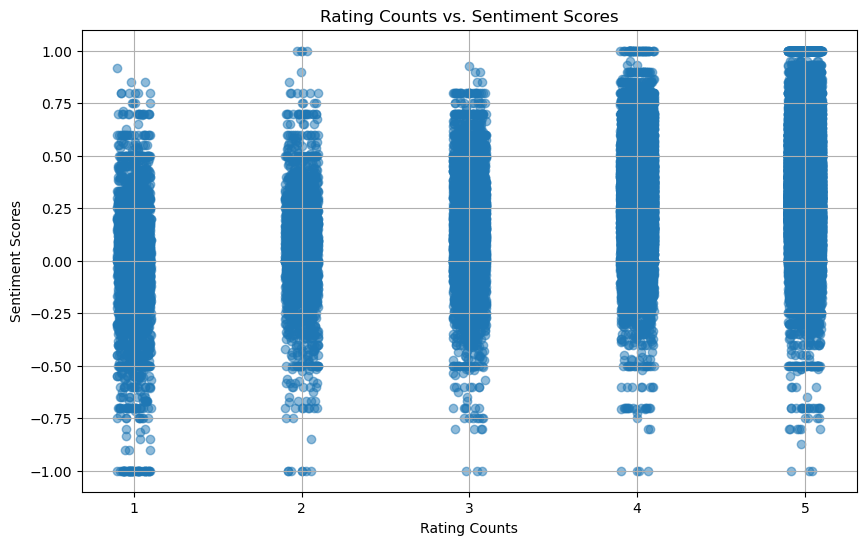

In [148]:
ratings = expanded_df['Rating Counts'].values
# Extract the 'Sentiment Scores' as an array-like object
sentiment_scores = expanded_df['Sentiment Scores'].values

# Add jitter to the ratings for plotting
ratings_jittered = ratings + np.random.uniform(-0.1, 0.1, size=len(ratings))

# Plot with jitter and alpha for transparency
plt.figure(figsize=(10, 6))
plt.scatter(ratings_jittered, sentiment_scores, alpha=0.5)
plt.xlabel('Rating Counts')
plt.ylabel('Sentiment Scores')
plt.title('Rating Counts vs. Sentiment Scores')
plt.grid(True)
plt.show()

# Scatter PLot Analysis
The scatter plot shows sentiment scores for reviews across a 1-to-5 rating system. Notably, while lower ratings (1's and 2's) predominantly have negative sentiment scores, as one would expect, there are still a considerable number of reviews at these rating levels with positive sentiment scores.

This could occur for several reasons:

Mixed Feedback: A review could contain both negative and positive comments, such as praising certain features while criticizing others. Sentiment analysis might pick up on the positive aspects, resulting in a higher sentiment score.

Reviewer Tendencies: Some users may use a harsh rating scale but still use positive language, or they might add a positive note to a generally negative review, such as acknowledging a single good feature in an otherwise disappointing product.

Sentiment Analysis Nuances: Sentiment analysis tools, like TextBlob used here, might interpret certain phrases or words as positive even within a largely critical context, leading to higher sentiment scores for low ratings.

Data Entry Errors: There could be inconsistencies where reviewers mistakenly select the wrong rating or provide a review that doesn't align with the rati given.

.

NMF Topics:
Topic 0:
car recommend looking buy amazing time want fast perfect price
Topic 1:
mile year bought problem new oil engine issue transmission used
Topic 2:
vehicle family recommend suv purchased looking purchase excellent highly dependable
Topic 3:
great run look value snow handle price performance condition money
Topic 4:
good really price nice value look condition pretty looking run
Topic 5:
need met meet family work expectation space fit perfect legroom
Topic 6:
room plenty leg lot family space trunk seat kid cargo
Topic 7:
truck cab bed looking work ranger ford tow towing trailer
Topic 8:
love absolutely kid way style color im look bought jeep
Topic 9:
owned ive best year far driven performance bmw value money
Topic 10:
drive fun easy wheel lot fast snow super convertible handle
Topic 11:
seat ride comfortable nice smooth interior power feature heated leather
Topic 12:
gas mileage better low highway excellent decent mpg tank city
Topic 13:
like new look feel really handle

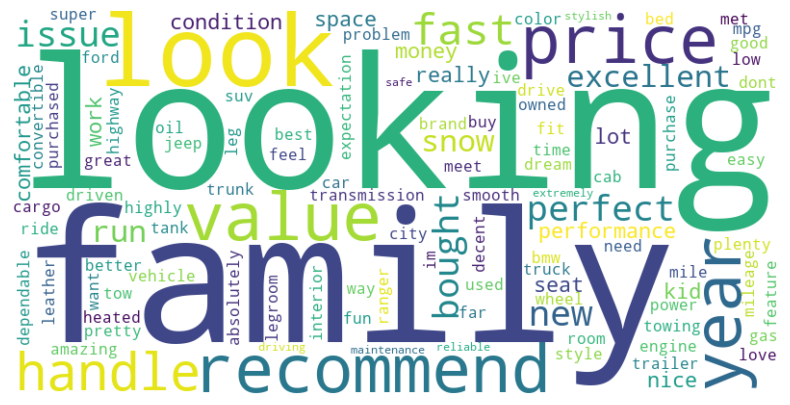

In [96]:
import pandas as pd
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Function to display NMF topics
def generate_wordcloud(text, title):
    wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

def display_topics(model, feature_names, no_top_words):
    all_words = []
    for topic_idx, topic in enumerate(model.components_):
        all_topic_words = " ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(f"Topic {topic_idx}:")
        print(all_topic_words)
        all_words.append(all_topic_words)
    all_words_str = " ".join(all_words)
    generate_wordcloud(all_words_str, "")

# Load stopwords
stop_words = set(stopwords.words('english'))

# Function to preprocess text
def preprocess_text(text):
    # Tokenization
    tokens = word_tokenize(text)
    # Lowercasing and removing stopwords
    tokens = [word.lower() for word in tokens if word.isalpha() and word.lower() not in stop_words]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)  # Join tokens into a single string

# Preprocess review bodies
expanded_df['Cleaned Text'] = expanded_df['Cleaned Review Bodies'].apply(preprocess_text)

# Create TF-IDF matrix
tfidf_vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
tfidf = tfidf_vectorizer.fit_transform(expanded_df['Cleaned Text'])

# Define number of topics and components
no_topics = 15
no_top_words = 10

# Fit NMF model
nmf_model = NMF(n_components=no_topics, random_state=1, init='nndsvd')
nmf_W = nmf_model.fit_transform(tfidf)
nmf_H = nmf_model.components_

# Display topics
print("NMF Topics:")
display_topics(nmf_model, tfidf_vectorizer.get_feature_names_out(), no_top_words)


# Analysis
The word cloud vividly encapsulates the prevalent sentiments within car reviews, showcasing the terms most frequently mentioned by consumers. Dominant in the visualization are words like "family," "recommend," and "comfortable," which point to a strong appreciation for vehicles that cater to family needs and comfort. Terms such as "value," "performance," and "reliable" are also prominently featured, indicating that practical performance metrics are central to customer satisfaction. The presence of emotive words like "love," "perfect," and "fun" alongside practical descriptors like "gas," "mileage," and "maintenance" reveals a balanced sentiment where emotional satisfaction intersects with functional appraisal. The large, central placement of "recommend" suggests a willingness among satisfied customers to endorse their vehicles to others. This word cloud, in summary, portrays a positive consumer landscape where the quality, utility, and emotional fulfillment derived from these vehicles are openly celebrated and are likely influential in guiding prospective buyers.s.